# Explore Postprocessing

This notebook looks at the post processing steps.

In [1194]:
#binary_dirs = 'binaries_model12_tfrecordz_pmcnoncom/'
#binary_dirs = 'binaries_model12_tfrecordz/'
binary_dirs = 'binaries_model1_tfrecordz/'
#binary_dirs = 'binaries_model11_tfrecordz/'
#binary_dirs = 'binaries_model2_tfrecordz/'

ocr_results_dir = None
make_sense_dir = None

In [1195]:
import config

#import time
#from lxml import etree
import os
import pandas as pd
import cv2 as cv
import numpy as np
from glob import glob
from PIL import Image
#import spacy
#nlp = spacy.load("en_core_web_sm")
import matplotlib.pyplot as plt
import pickle
import shutil

from annotation_utils import get_all_ocr_files, collect_ocr_process_results, \
   get_makesense_info_and_years

from general_utils import parse_annotation

from post_processing_utils import get_ocr_results, get_true_boxes, \
  get_image_process_boxes

from feature_generation_utils import generate_single_feature

from metric_utils import calc_base_metrics_allboxes_cv, calc_prec_rec_f1_cv,print_metrics_table, calc_base_metrics_allboxes_cv

In [1196]:
# for one-on-one
annotation_dir = config.save_binary_dir + config.ann_name + str(config.IMAGE_H) + 'x' + str(config.IMAGE_W) + '_ann/'
# get feature list
with open(config.save_binary_dir+binary_dirs + 'feature_list.pickle','rb') as f:
    feature_list = pickle.load(f)[0]
#feature_list

if not os.path.exists(config.tmp_storage_dir+'TMPTFRECORD/'):
    os.makedirs(config.tmp_storage_dir+'TMPTFRECORD/')

In [1197]:
# build up filename
pp = config.metric_results_dir
pp += binary_dirs.split('/')[0]
#pp += adder
pp += '.pickle'
with open(pp, 'rb') as ff:
    icombo,imgs_name, truebox, pdfboxes, pdfrawboxes, captionText_figcap,\
                 bbox_figcap_pars,\
                 sboxes_cleaned, slabels_cleaned, sscores_cleaned,\
                 boxes_pdf, labels_pdf, scores_pdf,\
                 boxes_heur, labels_heur, scores_heur,\
                 boxes_heur2, labels_heur2, scores_heur2,\
                 boxes_par_found, labels_par_found, scores_par_found,\
                 boxes_sq1, labels_sq1, scores_sq1,\
                 boxes_sq2, labels_sq2, scores_sq2,\
                 boxes_sq3, labels_sq3, scores_sq3,\
                 boxes_sq4, labels_sq4, scores_sq4,\
                 boxes_sq5, labels_sq5, scores_sq5,\
                 truebox1,truebox2,truebox3,rotatedImage,\
                 LABELS,boxes1, scores1, labels1 = pickle.load(ff)


In [1198]:
# let's get all of the ocr files
ocrFiles = get_all_ocr_files(ocr_results_dir=ocr_results_dir)
# get important quantities from these files
print('retreiving OCR data, this can take a moment...')
ws, paragraphs, squares, html, rotations,colorbars = collect_ocr_process_results(ocrFiles)
# create dataframe
df = pd.DataFrame({'ws':ws, 'paragraphs':paragraphs, 'squares':squares, 
                   'hocr':html, 'rotation':rotations, 'colorbars':colorbars})#, 'pdfwords':pdfwords})
df = df.drop_duplicates(subset='ws')
df = df.set_index('ws')

retreiving OCR data, this can take a moment...
##### OCR retrieval FILE: on 1 of 2  ##### 
--- OCR retrieval: on 0 of 5515 ---


KeyboardInterrupt: 

In [1082]:
dfMakeSense = get_makesense_info_and_years(df,make_sense_dir=make_sense_dir)

---- for some reason 1901ApJ____14__269C_p7 is not in this list -----
---- for some reason 1996ApJ___466_1087P_p8 is not in this list -----
---- for some reason 1979AJ_____84__910B_p10 is not in this list -----
---- for some reason 1989AJ_____98_1398H_p5 is not in this list -----
---- for some reason 1994ApJS___95__457W_p15 is not in this list -----
---- for some reason 1990ApJ___351__443U_p6 is not in this list -----
---- for some reason 1963ApJ___137__280W_p8 is not in this list -----
---- for some reason 1990ApJ___365__510C_p2 is not in this list -----
---- for some reason 1991ApJS___76__455E_p6 is not in this list -----
---- for some reason 1992AJ____103_1151C_p9 is not in this list -----
---- for some reason 1982ApJS___50____1W_p18 is not in this list -----
unique = 5515 pages


In [1083]:
# get labels list too
LABELS = pd.read_csv(config.save_binary_dir + binary_dirs + 'LABELS.csv', names=['l'])['l'].values.astype('str').tolist()
LABELS

['figure', 'figure caption', 'math formula', 'table']

In [1084]:
# save tmp binaries for this
def create_destroy_dirs(dirs):
    if not os.path.exists(dirs):
        os.makedirs(dirs)
    # delete and remake
    shutil.rmtree(dirs)
    os.makedirs(dirs)

 * Step 1 (truebox, boxes1): "raw" found boxes are compared to true boxes after non-maximum suppression is applied
 * Step 2 (truebox, sboxes_cleaned): if two found boxes overlap with an IOU $\ge$ 0.25 we remove the box with the lowest score.  This decreases the FP rate for captions at all IOU thresholds and for figures predominately at the high IOU thresholds.
 * Step 3 (truebox, boxes_pdf): if a raw or figure caption box is found through PDF mining and overlaps with a mega-yolo found box, use the PDF-mining results, which increases figure caption TP rate and decreases FP and FN at large IOU thresholds.  PDF-mining figure boxes are ignored.
 * Step 4 (truebox, boxes_heur): if a heuristically-found caption box overlaps with a mega-yolo-found box, take the top of the heuristic box (which tends to be more accurate) and the minimum (maximum) of the left (right, bottom) of the two boxes.  This results in an overall increase in FP while FN and FP drop.
 * Step 5 (truebox, boxes_par_found): grow found captions by their overlap with OCR word and paragraph boxes, allowing for multiple "grow" iterations in the horizontal direction.  For found boxes, only grow if centers of paragraph and word boxes overlap with the found box ~~(isn't this already done in the annotation step though?)~~
 * Step 6 (truebox, boxes_sq1): if found figure boxes overlap with image-processing squares, the found box is expanded to include the square.  This extends the TP rate at larger IOU thresholds.
 * Step 7 (truebox, boxes_sq2): any captions that have areas larger than 75% of the page area are discarded leading to a slight drop in FP for captions.
 * Step 8 (truebox, boxes_sq3): figure captions are matched to figures.  Any captions without an associated figure are dropped, leading to a drop in FP.
 * Step 9 (truebox2, boxes_sq4): both true and found figure boxes are extended down to the tops of their associated captions increasing TP for figures (and to a lesser extentent, captions) at high IOU thresholds.
 * Step 10 (truebox3, boxes_sq5): if a figure caption extends horizontally further than its associated figure, the figure is extended horizontally to the edges of the figure caption for both true and found boxes.  This leads to an increase in TP rates for figures at high IOU thresholds.

In [1085]:
# create a directory structure for all of this
save_dir = config.tmp_storage_dir + binary_dirs

create_destroy_dirs(save_dir)

# make steps directories
for i in range(11):
    os.mkdir(config.tmp_storage_dir + binary_dirs + 'Step' + str(i))

**Step 0:** Preliminary parsed annotations

In [1086]:
imgDirAnn = config.save_binary_dir + config.ann_name + str(int(config.IMAGE_H)) + 'x' + str(int(config.IMAGE_W))  + '_ann/'
imgDirAnn

'/Users/jillnaiman/MegaYolo/yolo_512x512_ann/'

In [1087]:
# get make sense info
dY = 10; dX = 10
larger_inds = []
dYs = []; dXs = []
inds_weird = []
for iw in range(len(dfMakeSense)):
    d = dfMakeSense.loc[dfMakeSense['filename']==dfMakeSense['filename'].values[iw]]
    noLabel = True
    if len(d['squares'].values) > 1:
        print('NOPE')
        import sys; sys.exit()
    for s in d['squares'].values[0]:
        if 'no label' not in s[-1]: noLabel = False
    # open
    ina, true_boxes, pdfboxes, \
       pdfrawboxes = parse_annotation([imgDirAnn + d['filename'].values[0]+'.xml'], 
                                      LABELS,
                                      feature_dir = config.save_binary_dir + binary_dirs,
                     annotation_dir = imgDirAnn, parse_pdf=True,
                                     check_for_file=False)   
    # sort
    if len(true_boxes) > 0:
        true_boxes1 = true_boxes[0] # formatted
        # take out others
        true_boxes = []
        for t in true_boxes1:
            if t[-1] != 0:
                true_boxes.append(t)
        true_boxes = np.array(true_boxes)
        #inds1 = np.lexsort( (true_boxes[:,0], true_boxes[:,1]) )
        #true_boxes = true_boxes[inds1]
        true_boxes = np.sort(true_boxes,axis=0)
        for i in range(len(true_boxes)):
            true_boxes[i,0] = true_boxes[i,0]/config.IMAGE_W*d['w'].values[0]
            true_boxes[i,2] = true_boxes[i,2]/config.IMAGE_W*d['w'].values[0]
            true_boxes[i,1] = true_boxes[i,1]/config.IMAGE_H*d['h'].values[0]
            true_boxes[i,3] = true_boxes[i,3]/config.IMAGE_H*d['h'].values[0]
    if not noLabel and len(true_boxes)>0:
        found_boxes = [] # original
        for s in d['squares'].values[0]:
            if 'no label' not in s[-1]:
                try:
                    found_boxes.append([s[0],s[1],s[0]+s[2],s[1]+s[3],
                                        LABELS.index(s[-1])+1])
                except:
                    f = 0
                    
        # sort
        found_boxes = np.array(found_boxes)
        #inds = np.lexsort( (found_boxes[:,0], found_boxes[:,1]) )
        #found_boxes = found_boxes[inds]
        found_boxes = np.sort(found_boxes,axis=0)
        # round trues!
        true_boxes = np.round(true_boxes).astype('int')
        # found boxes should be smaller than true boxes
        for t,f in zip(true_boxes,found_boxes):
            #if f[0]<t[0] or f[1]<t[1] or f[2]>t[2] or f[3]>t[3]:
            if t[0]<f[0]-dX or t[1]<f[1]-dY or t[2]>f[2]+dX or t[3]>f[3]+dY:
                larger_inds.append(iw)
                dXs.append([t[0]-f[0],f[2]-t[2]])
                dYs.append([t[1]-f[1],f[3]-t[3]])
                if t[-1] != LABELS.index('figure caption')+1 or f[-1] != LABELS.index('figure caption')+1:
                    inds_weird.append((iw,t[-1],f[-1]))
                    #print('open tmp',ina[0].split('/')[-1].split('.npz')[0])
                    #import sys; sys.exit()
                #import sys; sys.exit()

In [1088]:
#LABELS.index('figure caption')
len(inds_weird), len(np.unique(larger_inds))

(27, 269)

In [1089]:
#min([iweird+10,len(inds_weird)])

In [1090]:
#inds_weird

1994ApJ___427__656M_p3
1994ApJ___430__800F_p7
1995ApJ___440__634R_p6
1996ApJ___461__828W_p16
1996ApJ___461__847W_p1
1996ApJ___461__847W_p1
1996ApJ___472__398B_p7


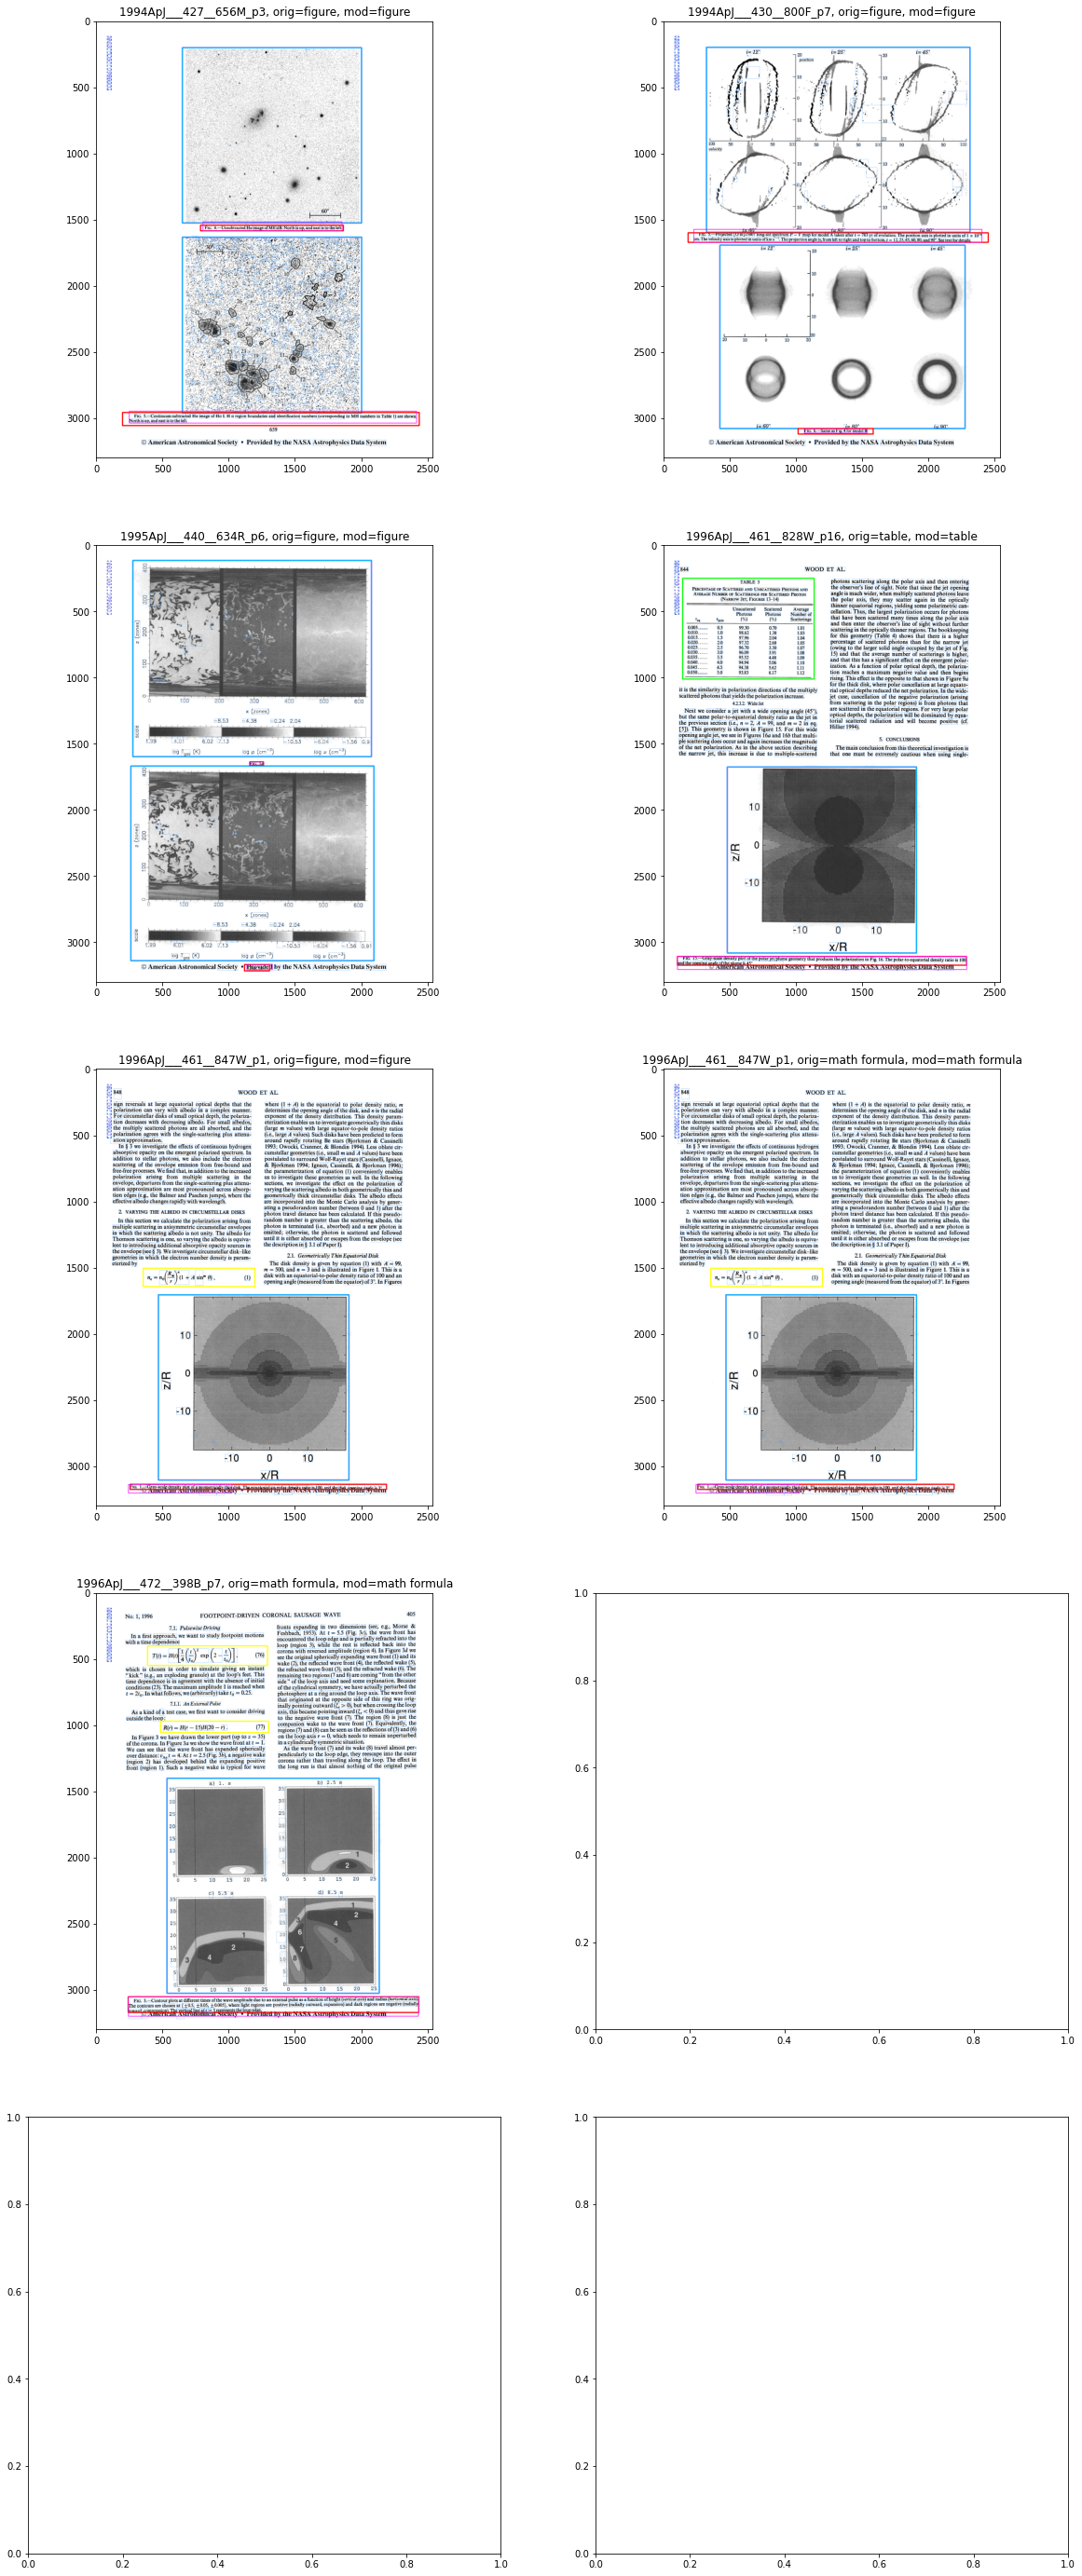

In [1091]:
iweird = 20

plt.close('all')
fig, ax = plt.subplots(5,2,figsize=(20,50))
ax = ax.flatten()
for i in range(iweird,min([iweird+10,len(inds_weird)])):
    fname = config.tmp_storage_dir + 'tmpAnnDiags/' + dfMakeSense.iloc[inds_weird[i][0]]['filename'] + '.png'
    img = np.array(Image.open(fname).convert('RGB'))
    ax[i-iweird].imshow(img)
    ax[i-iweird].set_title(dfMakeSense.iloc[inds_weird[i][0]]['filename']+', orig='+LABELS[inds_weird[i][2]-1]+', mod='+LABELS[inds_weird[i][1]-1])
    print(dfMakeSense.iloc[inds_weird[i][0]]['filename'])
    del img
plt.show()


In [1092]:
larger_inds = np.unique(larger_inds)
len(larger_inds)

269

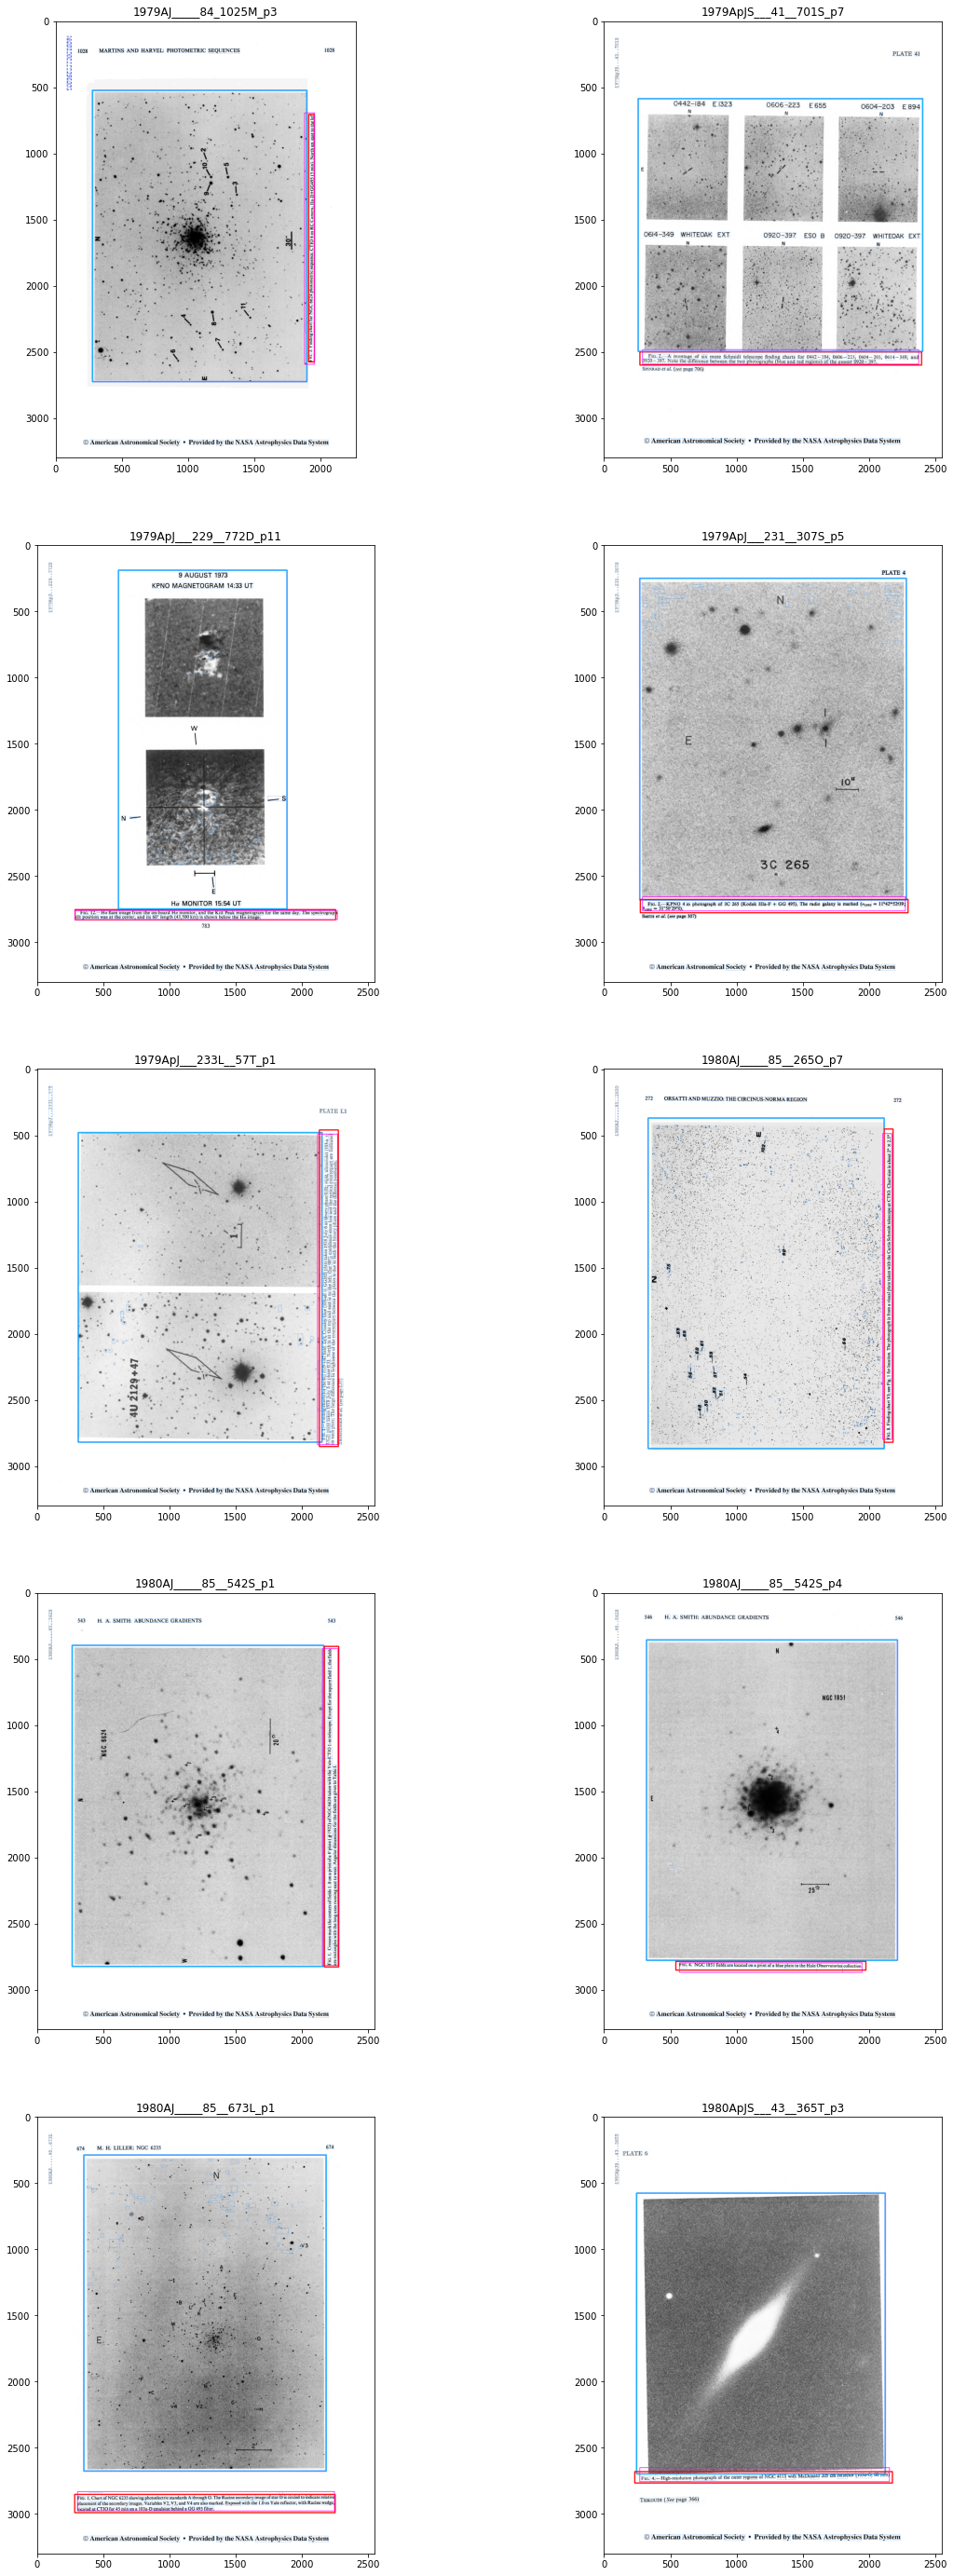

In [1093]:
iweird = 100

plt.close('all')
fig, ax = plt.subplots(5,2,figsize=(20,50))
ax = ax.flatten()
for i in range(iweird,min([iweird+10,len(larger_inds)])):
    fname = config.tmp_storage_dir + 'tmpAnnDiags/' + dfMakeSense.iloc[larger_inds[i]]['filename'] + '.png'
    img = np.array(Image.open(fname).convert('RGB'))
    ax[i-iweird].imshow(img)
    ax[i-iweird].set_title(dfMakeSense.iloc[larger_inds[i]]['filename'])
    #print(dfMakeSense.iloc[larger_inds[i]]['filename'])
    del img
plt.show()

In [1094]:
# fig, ax = plt.subplots(2,2,figsize=(10*2,5*2))

# nbin = 500
# ax[0][0].hist(dXs[:,0],bins=nbin)
# #ax[0][0].set_title('
# ax[0][1].hist(dXs[:,1],bins=nbin)

# ax[1][0].hist(dYs[:,0],bins=nbin)
# ax[1][1].hist(dYs[:,1],bins=nbin)

# for k in range(2):
#     for m in range(2):
#         ax[k][m].set_xlim(-100,100)

# plt.show()

In [1095]:
colfig_true = (0,0,255) # true fig is blue
colcap_true = (0,255,255) # true cap is cyan
coltable_true = (0,255,0) # true table is green

colfig_found = (255,0,0) # found fig is red
colcap_found = (255,0,255) # found cap is magenta
coltable_found = (255,255,0) # found table is yellow

**Step 1 (truebox, boxes1):** "raw" found boxes are compared to true boxes after non-maximum suppression is applied

In [1096]:
# Step 1 -- make images to save
for iloop,(tb,fb,l,imn) in enumerate(zip(truebox, boxes1, labels1,imgs_name)):
    if iloop%100 == 0: print(iloop,'of',len(imgs_name))
    if len(tb) > 0 or len(fb) > 0:
        #import sys; sys.exit()
        iname = config.images_jpeg_dir + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        img = np.array(Image.open(iname).convert('RGB'))
        # draw figures
        for t in tb:
            xmin = t[0]/config.IMAGE_W*img.shape[1]; xmax = t[2]/config.IMAGE_W*img.shape[1]
            ymin = t[1]/config.IMAGE_H*img.shape[0]; ymax = t[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[int(t[-1]-1)]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_true, 7)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_true, 7)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_true, 7)
        for f,ll in zip(fb,l):
            xmin = f[0]/config.IMAGE_W*img.shape[1]; xmax = f[2]/config.IMAGE_W*img.shape[1]
            ymin = f[1]/config.IMAGE_H*img.shape[0]; ymax = f[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[ll]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_found, 4)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_found, 4)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_found, 4)
                
        # save
        inameout = config.tmp_storage_dir + binary_dirs + 'Step1/' + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        Image.fromarray(img).save(inameout)
        del img

0 of 549
100 of 549
200 of 549
300 of 549
400 of 549
500 of 549


**Step 2 (truebox, sboxes_cleaned):** if two found boxes overlap with an IOU $\ge$ 0.25 we remove the box with the lowest score.  This decreases the FP rate for captions at all IOU thresholds and for figures predominately at the high IOU thresholds.

In [841]:
# Step 2 -- only save if different from before
# Step 2 (truebox, sboxes_cleaned)
for iloop,(tb,fb1,lab1,fb2,lab2,imn) in enumerate(zip(truebox, boxes1, labels1,sboxes_cleaned, slabels_cleaned, imgs_name)):
    if iloop%100 == 0: print(iloop,'of',len(imgs_name))
    dontPlot = True
    if len(tb) > 0 or len(fb) > 0: # do we have something?
        if len(lab1) != len(lab2): # different number of labels
            dontPlot = False # gotta plot it!
        else:
            # check to see if any of them have changed, box-wise
            newBox = []
            for b1 in fb1:
                # look for index
                try:
                    fb2.tolist().index(b1.tolist())
                    newBox.append(False)
                except: # not in there
                    newBox.append(True)
            if np.array(newBox).any(): # do we have at least one new box?
                dontPlot = False
            else:
                dontPlot = True
                
    if not dontPlot: # if anything has happened, plot!
        iname = config.images_jpeg_dir + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        img = np.array(Image.open(iname).convert('RGB'))
        # draw figures
        for t in tb:
            xmin = t[0]/config.IMAGE_W*img.shape[1]; xmax = t[2]/config.IMAGE_W*img.shape[1]
            ymin = t[1]/config.IMAGE_H*img.shape[0]; ymax = t[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[int(t[-1]-1)]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_true, 7)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_true, 7)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_true, 7)
        for f,ll in zip(fb2,lab2): # only plot new boxes!
            xmin = f[0]/config.IMAGE_W*img.shape[1]; xmax = f[2]/config.IMAGE_W*img.shape[1]
            ymin = f[1]/config.IMAGE_H*img.shape[0]; ymax = f[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[ll]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_found, 4)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_found, 4)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_found, 4)
                
        # save
        inameout = config.tmp_storage_dir + binary_dirs + 'Step2/' + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        Image.fromarray(img).save(inameout)
        del img

0 of 549
100 of 549
200 of 549
300 of 549
400 of 549
500 of 549


**Step 3 (truebox, boxes_pdf):** if a raw or figure caption box is found through PDF mining and overlaps with a mega-yolo found box, use the PDF-mining results, which increases figure caption TP rate and decreases FP and FN at large IOU thresholds.  PDF-mining figure boxes are ignored.


In [1199]:
#abase = '1994ApJS___90__833M_p1'
#abase = '1988ApJ___335__552T_p35'
abase = '1996ApJ___462__339W_p2'
#abase = '1942ApJ____95__461K_p4'
#abase = '1981ApJ___243L_137H_p1'
#abase = '1982ApJ___257L__77J_p6'

In [1200]:
# for a particular one
a = annotation_dir+abase+'.xml'
feature_dir = config.save_binary_dir + binary_dirs

imgs_nameh, pdfboxesh, pdfrawboxesh,years_indh, trueboxh = get_true_boxes(a,LABELS,
                                                   [],[],
                                                   annotation_dir=annotation_dir,
                                                  feature_dir=feature_dir,
                                                    check_for_file=False)
dfsingle = df.loc[abase+'.jpeg']

In [1201]:
isave = -1
for iiname,iname in enumerate(imgs_name):
    if abase in iname:
        isave=iiname

In [1202]:
imgs_name[isave]

'/Users/jillnaiman/MegaYolo/binaries_model1_tfrecordz/1996ApJ___462__339W_p2.npz'

In [1203]:
from importlib import reload
import post_processing_utils
reload(post_processing_utils)
from post_processing_utils import clean_overlapping_squares, clean_merge_pdfsquares

In [1204]:
# sboxes_cleanedh, slabels_cleanedh, sscores_cleanedh = clean_overlapping_squares(boxes1[isave],
#                                                                              scores1[isave],
#                                                                              labels1[isave],
#                                                                              imgs_name[isave])

ff = imgs_name[isave].split('/')[-1].split('.npz')[0]
dfMS = dfMakeSense.loc[dfMakeSense['filename']==ff]


# merge with any boxes that have been found with PDF mining
# found figures are generally not accurate, so ignore these, but do 
# assume any tables or figure captions are more accurate from PDF mining
boxes_pdfh, labels_pdfh, scores_pdfh = clean_merge_pdfsquares(pdfboxesh,
                                                           pdfrawboxesh,
                                                           sboxes_cleaned[isave], 
                                                           slabels_cleaned[isave], 
                                                           sscores_cleaned[isave], 
                                                           LABELS, dfMS)


In [1205]:
# plot and show
img = np.array(Image.open(config.images_jpeg_dir+imgs_name[isave].split('/')[-1].split('.npz')[0]+'.jpeg').convert('RGB'))

In [1206]:
fracx = img.shape[1]/config.IMAGE_W; fracy = img.shape[0]/config.IMAGE_H

In [1207]:
# draw orig
imgPlot1 = img.copy()
for b,s,l in zip(boxes1[isave],scores1[isave],labels1[isave]):
    xmin,ymin,xmax,ymax = b
    xmin=xmin*fracx; xmax*=fracx
    ymin*=fracy; ymax*=fracy
    if LABELS[l] == 'figure':
        cv.rectangle(imgPlot1, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_found, 5)
    elif LABELS[l] == 'figure caption':
        cv.rectangle(imgPlot1, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_found, 5)
    elif LABELS[l] == 'table':
        cv.rectangle(imgPlot1, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_found, 5)
    else:
        cv.rectangle(imgPlot1, (round(xmin), round(ymin)), (round(xmax),round(ymax)), (125,125,125), 5)    
# draw new
imgPlot2 = img.copy()
for b,l,s in zip(boxes_pdfh, labels_pdfh, scores_pdfh):
    xmin,ymin,xmax,ymax = b
    xmin=xmin*fracx; xmax*=fracx
    ymin*=fracy; ymax*=fracy
    if LABELS[l] == 'figure':
        cv.rectangle(imgPlot2, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_found, 7)
    if LABELS[l] == 'figure caption':
        cv.rectangle(imgPlot2, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_found, 7)
    if LABELS[l] == 'table':
        cv.rectangle(imgPlot2, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_found, 7)

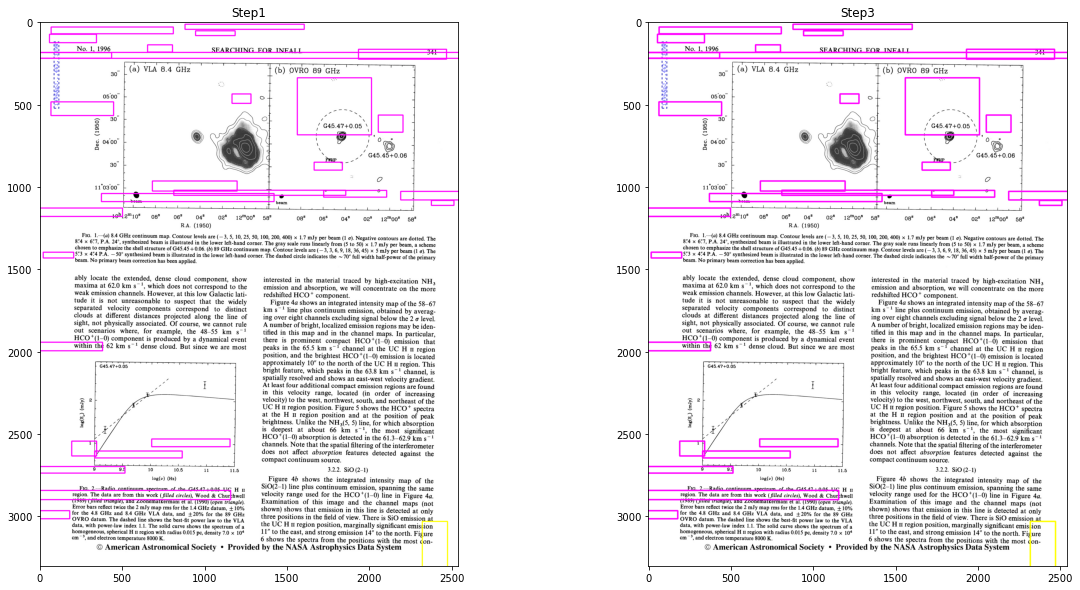

In [1208]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(imgPlot1)
ax[0].set_title('Step1')

ax[1].imshow(imgPlot2)
ax[1].set_title('Step3')
plt.show()

Full Step 3 run:

In [1029]:
sname='Step3/'
for iloop,(tb,fb1,lab1,fb2,lab2,imn) in enumerate(zip(truebox, boxes1, labels1,boxes_pdf, labels_pdf, imgs_name)):
    if iloop%100 == 0: print(iloop,'of',len(imgs_name))
    dontPlot = True
    if len(tb) > 0 or len(fb) > 0: # do we have something?
        if len(lab1) != len(lab2): # different number of labels
            dontPlot = False # gotta plot it!
        else:
            # check to see if any of them have changed, box-wise
            newBox = []
            for b1 in fb1:
                # look for index
                try:
                    fb2.tolist().index(b1.tolist())
                    newBox.append(False)
                except: # not in there
                    newBox.append(True)
            if np.array(newBox).any(): # do we have at least one new box?
                dontPlot = False
            else:
                dontPlot = True
                
    if not dontPlot: # if anything has happened, plot!
        iname = config.images_jpeg_dir + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        img = np.array(Image.open(iname).convert('RGB'))
        # draw figures
        for t in tb:
            xmin = t[0]/config.IMAGE_W*img.shape[1]; xmax = t[2]/config.IMAGE_W*img.shape[1]
            ymin = t[1]/config.IMAGE_H*img.shape[0]; ymax = t[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[int(t[-1]-1)]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_true, 7)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_true, 7)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_true, 7)
        for f,ll in zip(fb2,lab2): # only plot new boxes!
            xmin = f[0]/config.IMAGE_W*img.shape[1]; xmax = f[2]/config.IMAGE_W*img.shape[1]
            ymin = f[1]/config.IMAGE_H*img.shape[0]; ymax = f[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[ll]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_found, 4)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_found, 4)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_found, 4)
                
        # save
        inameout = config.tmp_storage_dir + binary_dirs + sname + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        Image.fromarray(img).save(inameout)
        del img

0 of 549
100 of 549
200 of 549


KeyboardInterrupt: 

**Step 4 (truebox, boxes_heur):** if a heuristically-found caption box overlaps with a mega-yolo-found box, take the top of the heuristic box (which tends to be more accurate) and the minimum (maximum) of the left (right, bottom) of the two boxes.  This results in an overall increase in FP while FN and FP drop.


In [1063]:
abase = '1942ApJ____95__461K_p4'
abase = '1981ApJ___243L_137H_p1'
abase = '1982ApJ___257L__77J_p6'
abase = '1996ApJ___462__339W_p2'


In [1066]:
# for a single one

create_destroy_dirs(config.tmp_storage_dir+'TMPTFRECORD/')

a = annotation_dir+abase+'.xml'
feature_dir = config.save_binary_dir + binary_dirs

imgs_nameh, pdfboxesh, pdfrawboxesh,years_ind, trueboxh = get_true_boxes(a,LABELS,
                                                   [],[],
                                                   annotation_dir=annotation_dir,
                                                  feature_dir=feature_dir,
                                                    check_for_file=False)
dfsingle = df.loc[abase+'.jpeg']

# if we've made it this far, let's generate features
feature_name, font = generate_single_feature(dfsingle, LABELS,
                                             maxboxes=20, 
                                       feature_list = feature_list, 
                                       binary_dir = config.tmp_storage_dir)

image = np.load(feature_name)['arr_0']
backtorgb,image_np,rotatedImage,rotatedAngleOCR,bbox_hocr,\
  bboxes_words,bbsq,cbsq, rotation,bbox_par = get_ocr_results(imgs_nameh, 
                                                              dfMakeSense,df,
                                                             image_np=image)

In [1067]:
captionText_figcap, bbox_figcap_pars = get_image_process_boxes(backtorgb, 
                                                               bbox_hocr, 
                                                               rotatedImage)

In [1068]:
isave = -1
for iiname,iname in enumerate(imgs_name):
    if abase in iname:
        isave=iiname
imgs_name[isave]

'/Users/jillnaiman/MegaYolo/binaries_model12_tfrecordz/1996ApJ___462__339W_p2.npz'

In [1069]:
from importlib import reload
import post_processing_utils
reload(post_processing_utils)
from post_processing_utils import clean_merge_heurstic_captions

In [1070]:
ff = imgs_name[isave].split('/')[-1].split('.npz')[0]
dfMS = dfMakeSense.loc[dfMakeSense['filename']==ff]

boxes_heurh, labels_heurh, scores_heurh,\
  ibbOverlaph, boxes_heur_tfh  = clean_merge_heurstic_captions(boxes_pdf[isave], 
                                        labels_pdf[isave], scores_pdf[isave], 
                                        bbox_figcap_pars, LABELS,dfMS)

In [1071]:
img = np.array(Image.open(config.images_jpeg_dir+imgs_nameh[0].split('/')[-1].split('.npz')[0]+'.jpeg').convert('RGB'))
fracx = img.shape[1]/config.IMAGE_W; fracy = img.shape[0]/config.IMAGE_H

In [1072]:
# overplot
imgPlot1 = img.copy()
for b in bbox_figcap_pars:
    xmin = b[0]; ymin=b[1]
    xmax = b[2]; ymax = b[3]
    cv.rectangle(imgPlot1, (round(xmin), round(ymin)), 
                 (round(xmax),round(ymax)), (255,0,0), 5)
    
# imgPlot3 = img.copy()
# for bb in bbox_hocr:
#     b = bb[0] 
#     xmin = b[0]; ymin=b[1]
#     xmax = b[2]+b[0]; ymax = b[3]+b[1]
#     cv.rectangle(imgPlot2, (round(xmin), round(ymin)), 
#                  (round(xmax),round(ymax)), (255,0,0), 5)
    
imgPlot2 = img.copy()
for b in boxes_heurh:
    xmin = b[0]*fracx; ymin=b[1]*fracy
    xmax = b[2]*fracx; ymax = b[3]*fracy
    cv.rectangle(imgPlot2, (round(xmin), round(ymin)), 
                 (round(xmax),round(ymax)), (255,0,0), 5)

In [1073]:
#bbox_hocr[1]

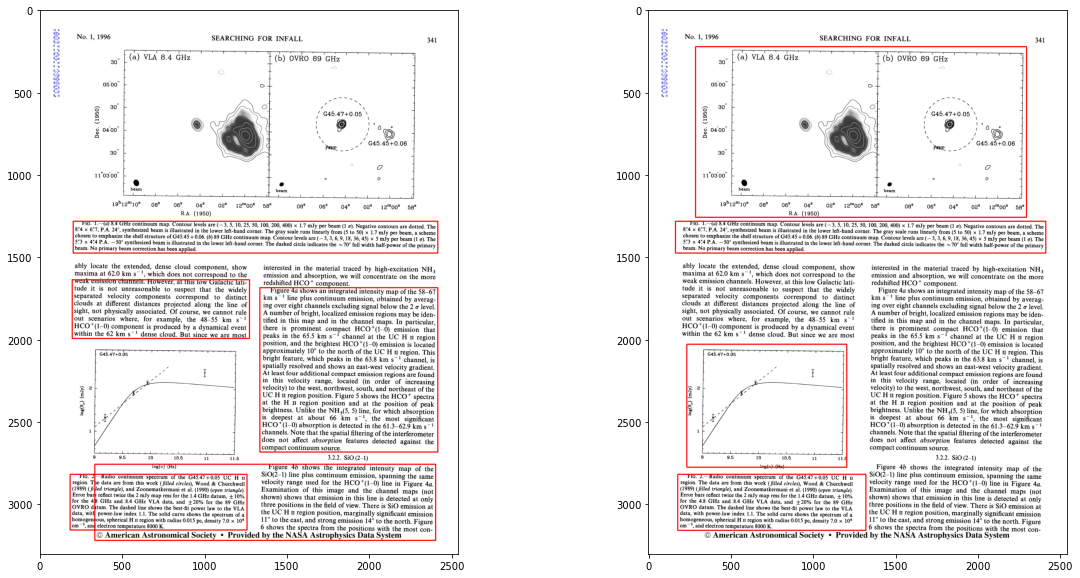

In [1076]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(imgPlot1)

ax[1].imshow(imgPlot2)

#ax[2].imshow(imgPlot3)
plt.show()

In [863]:
sname='Step4/'
for iloop,(tb,fb1,lab1,fb2,lab2,imn) in enumerate(zip(truebox, boxes1, labels1,boxes_heur, labels_heur, imgs_name)):
    if iloop%100 == 0: print(iloop,'of',len(imgs_name))
    dontPlot = True
    if len(tb) > 0 or len(fb) > 0: # do we have something?
        if len(lab1) != len(lab2): # different number of labels
            dontPlot = False # gotta plot it!
        else:
            # check to see if any of them have changed, box-wise
            newBox = []
            for b1 in fb1:
                # look for index
                try:
                    fb2.tolist().index(b1.tolist())
                    newBox.append(False)
                except: # not in there
                    newBox.append(True)
            if np.array(newBox).any(): # do we have at least one new box?
                dontPlot = False
            else:
                dontPlot = True
                
    if not dontPlot: # if anything has happened, plot!
        iname = config.images_jpeg_dir + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        img = np.array(Image.open(iname).convert('RGB'))
        # draw figures
        for t in tb:
            xmin = t[0]/config.IMAGE_W*img.shape[1]; xmax = t[2]/config.IMAGE_W*img.shape[1]
            ymin = t[1]/config.IMAGE_H*img.shape[0]; ymax = t[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[int(t[-1]-1)]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_true, 7)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_true, 7)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_true, 7)
        for f,ll in zip(fb2,lab2): # only plot new boxes!
            xmin = f[0]/config.IMAGE_W*img.shape[1]; xmax = f[2]/config.IMAGE_W*img.shape[1]
            ymin = f[1]/config.IMAGE_H*img.shape[0]; ymax = f[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[ll]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_found, 4)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_found, 4)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_found, 4)
                
        # save
        inameout = config.tmp_storage_dir + binary_dirs + sname + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        Image.fromarray(img).save(inameout)
        del img

0 of 549
100 of 549
200 of 549
300 of 549
400 of 549
500 of 549


**Step 5 (~~truebox1~~ truebox, boxes_par_found)**: grow found captions by their overlap with OCR word and paragraph boxes, allowing for multiple "grow" iterations in the horizontal direction.  For found boxes, only grow if centers of paragraph and word boxes overlap with the box

In [864]:
sname='Step5/'
for iloop,(tb,fb1,lab1,fb2,lab2,imn) in enumerate(zip(truebox,boxes_heur, labels_heur, 
                                                      boxes_par_found, labels_par_found,
                                                      imgs_name)):
    if iloop%100 == 0: print(iloop,'of',len(imgs_name))
    dontPlot = True
    if len(tb) > 0 or len(fb) > 0: # do we have something?
        if len(lab1) != len(lab2): # different number of labels
            dontPlot = False # gotta plot it!
        else:
            # check to see if any of them have changed, box-wise
            newBox = []
            for b1 in fb1:
                # look for index
                try:
                    fb2.tolist().index(b1.tolist())
                    newBox.append(False)
                except: # not in there
                    newBox.append(True)
            if np.array(newBox).any(): # do we have at least one new box?
                dontPlot = False
            else:
                dontPlot = True
                
    if not dontPlot: # if anything has happened, plot!
        iname = config.images_jpeg_dir + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        img = np.array(Image.open(iname).convert('RGB'))
        # draw figures
        for t in tb:
            xmin = t[0]/config.IMAGE_W*img.shape[1]; xmax = t[2]/config.IMAGE_W*img.shape[1]
            ymin = t[1]/config.IMAGE_H*img.shape[0]; ymax = t[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[int(t[-1]-1)]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_true, 7)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_true, 7)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_true, 7)
        for f,ll in zip(fb2,lab2): # only plot new boxes!
            xmin = f[0]/config.IMAGE_W*img.shape[1]; xmax = f[2]/config.IMAGE_W*img.shape[1]
            ymin = f[1]/config.IMAGE_H*img.shape[0]; ymax = f[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[ll]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_found, 4)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_found, 4)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_found, 4)
                
        # save
        inameout = config.tmp_storage_dir + binary_dirs + sname + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        Image.fromarray(img).save(inameout)
        del img

0 of 549
100 of 549
200 of 549
300 of 549
400 of 549
500 of 549


In [1210]:
len(truebox)

549

In [1268]:
reload(metric_utils)
from metric_utils import calc_base_metrics_allboxes_cv, calc_prec_rec_f1_cv, print_metrics_table

In [1269]:
ious = np.repeat(0.9,4)#[0.8,0.8,0.8,0.8]
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[0.1],ious,
                                              truebox,boxes_par_found, labels_par_found, 
                                              scores_par_found,n_folds_cv=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[0.1],
                                               ious)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, 0.1, 5, ious)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.9             0.9             0.9            
# of objs       497             487             75              60             
--------------------------------------------------------------------------------------------
TP              0.8%            62.8%           0.0%            1.7%           
FP              202.4%          1697.5%         60.0%           373.3%         
FN              33.2%           0.0%            97.3%           53.3%          
--------------------------------------------------------------------------------------------
Precision       0.4+/-0.4%      3.6+/-0.5%      0.0+/-0.0%      0.6+/-1.1%     
Recall          2.4+/-2.1%      100.0+/-0.0%    0.0+/-0.0%      1.7+/-3.3%     
F1              0.7+/-0.6%      6.9+/-0.9%      0.0+/-0.0%      0.8+/-1.7%     


In [1263]:
#labels_par_found

In [999]:
# stepName = 'Step5_FP_cap/'
# create_destroy_dirs(save_dir + stepName)

# iou_FP = 0.9
# for i in range(len(truebox)):
#     if i%100 == 0: print(i,'of',len(imgs_name))
#     TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[0.1],[iou_FP],
#                                               [truebox[i]],[np.round(boxes_par_found[i])], 
#                                                               [labels_par_found[i]], 
#                                               [scores_par_found[i]],n_folds_cv=1)
    
#     FPs = FPs[:,0,0,0]; FNs = FNs[:,0,0,0]; TPs = TPs[:,0,0,0]
#     imn = imgs_name[i]
#     tb = truebox[i]; fb = boxes_par_found[i]; l=labels_par_found[i]
#     #if (FPs[0] == 1) or (FPs[1]==1): # fig or caption FP
#     if (FPs[LABELS.index('figure caption')]==1): # fig or caption FP
#         if len(tb) > 0 or len(fb) > 0:
#             #import sys; sys.exit()
#             iname = config.images_jpeg_dir + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
#             img = np.array(Image.open(iname).convert('RGB'))
#             # draw figures
#             for t in tb:
#                 xmin = t[0]/config.IMAGE_W*img.shape[1]; 
#                 xmax = t[2]/config.IMAGE_W*img.shape[1]
#                 ymin = t[1]/config.IMAGE_H*img.shape[0]; 
#                 ymax = t[3]/config.IMAGE_H*img.shape[0]
#                 l2 = LABELS[int(t[-1]-1)]
#                 if l2 == 'figure':
#                     cv.rectangle(img, (round(xmin), round(ymin)), 
#                                  (round(xmax),round(ymax)), colfig_true, 7)
#                 if l2 == 'figure caption':
#                     cv.rectangle(img, (round(xmin), round(ymin)), 
#                                  (round(xmax),round(ymax)), colcap_true, 7)
#                 if l2 == 'table':
#                     cv.rectangle(img, (round(xmin), round(ymin)), 
#                                  (round(xmax),round(ymax)), coltable_true, 7)
#             for f,ll in zip(fb,l):
#                 xmin = f[0]/config.IMAGE_W*img.shape[1]; 
#                 xmax = f[2]/config.IMAGE_W*img.shape[1]
#                 ymin = f[1]/config.IMAGE_H*img.shape[0]; 
#                 ymax = f[3]/config.IMAGE_H*img.shape[0]
#                 l2 = LABELS[ll]
#                 if l2 == 'figure':
#                     cv.rectangle(img, (round(xmin), round(ymin)), 
#                                  (round(xmax),round(ymax)), colfig_found, 4)
#                 if l2 == 'figure caption':
#                     cv.rectangle(img, (round(xmin), round(ymin)), 
#                                  (round(xmax),round(ymax)), colcap_found, 4)
#                 if l2 == 'table':
#                     cv.rectangle(img, (round(xmin), round(ymin)), 
#                                  (round(xmax),round(ymax)), coltable_found, 4)

#             # save
#             inameout = config.tmp_storage_dir + binary_dirs + stepName + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
#             Image.fromarray(img).save(inameout)
#             del img    
#             #import sys; sys.exit()
#             #if '1906ApJ____23__255P_p1' in inameout: import sys; sys.exit()

**Step 6 (truebox, boxes_sq1):** if found figure boxes overlap with image-processing squares, the found box is expanded to include the square.  This extends the TP rate at larger IOU thresholds.

In [1002]:
sname='Step6/'
for iloop,(tb,fb1,lab1,fb2,lab2,imn) in enumerate(zip(truebox,boxes_par_found, 
                                                      labels_par_found, 
                                                      boxes_sq1, labels_sq1,
                                                      imgs_name)):
    if iloop%100 == 0: print(iloop,'of',len(imgs_name))
    dontPlot = True
    if len(tb) > 0 or len(fb) > 0: # do we have something?
        if len(lab1) != len(lab2): # different number of labels
            dontPlot = False # gotta plot it!
        else:
            # check to see if any of them have changed, box-wise
            newBox = []
            for b1 in fb1:
                # look for index
                try:
                    fb2.tolist().index(b1.tolist())
                    newBox.append(False)
                except: # not in there
                    newBox.append(True)
            if np.array(newBox).any(): # do we have at least one new box?
                dontPlot = False
            else:
                dontPlot = True
                
    if not dontPlot: # if anything has happened, plot!
        iname = config.images_jpeg_dir + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        img = np.array(Image.open(iname).convert('RGB'))
        # draw figures
        for t in tb:
            xmin = t[0]/config.IMAGE_W*img.shape[1]; xmax = t[2]/config.IMAGE_W*img.shape[1]
            ymin = t[1]/config.IMAGE_H*img.shape[0]; ymax = t[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[int(t[-1]-1)]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_true, 7)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_true, 7)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_true, 7)
        for f,ll in zip(fb2,lab2): # only plot new boxes!
            xmin = f[0]/config.IMAGE_W*img.shape[1]; xmax = f[2]/config.IMAGE_W*img.shape[1]
            ymin = f[1]/config.IMAGE_H*img.shape[0]; ymax = f[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[ll]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_found, 4)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_found, 4)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_found, 4)
                
        # save
        inameout = config.tmp_storage_dir + binary_dirs + sname + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        Image.fromarray(img).save(inameout)
        del img

0 of 549
100 of 549
200 of 549
300 of 549
400 of 549
500 of 549


In [1270]:
ious = np.repeat(0.9,4)#[0.8,0.8,0.8,0.8]
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[0.1],ious,
                                              truebox,boxes_sq1, labels_sq1, 
                                              scores_sq1,n_folds_cv=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[0.1],
                                               ious)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, 0.1, 5, ious)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.9             0.9             0.9            
# of objs       497             487             75              60             
--------------------------------------------------------------------------------------------
TP              18.7%           62.8%           0.0%            1.7%           
FP              184.5%          1697.5%         60.0%           373.3%         
FN              33.2%           0.0%            97.3%           53.3%          
--------------------------------------------------------------------------------------------
Precision       9.2+/-0.3%      3.6+/-0.3%      0.0+/-0.0%      0.4+/-0.8%     
Recall          36.4+/-4.1%     100.0+/-0.0%    0.0+/-0.0%      1.8+/-3.6%     
F1              14.7+/-0.3%     6.9+/-0.5%      0.0+/-0.0%      0.6+/-1.3%     


**Step 7 (truebox, boxes_sq2):** any captions that have areas larger than 75% of the page area are discarded leading to a slight drop in FP for captions.


In [1004]:
sname='Step7/'
for iloop,(tb,fb1,lab1,fb2,lab2,imn) in enumerate(zip(truebox,boxes_sq1, labels_sq1, 
                                                      boxes_sq2, labels_sq2,
                                                      imgs_name)):
    if iloop%100 == 0: print(iloop,'of',len(imgs_name))
    dontPlot = True
    if len(tb) > 0 or len(fb) > 0: # do we have something?
        if len(lab1) != len(lab2): # different number of labels
            dontPlot = False # gotta plot it!
        else:
            # check to see if any of them have changed, box-wise
            newBox = []
            for b1 in fb1:
                # look for index
                try:
                    fb2.tolist().index(b1.tolist())
                    newBox.append(False)
                except: # not in there
                    newBox.append(True)
            if np.array(newBox).any(): # do we have at least one new box?
                dontPlot = False
            else:
                dontPlot = True
                
    if not dontPlot: # if anything has happened, plot!
        iname = config.images_jpeg_dir + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        img = np.array(Image.open(iname).convert('RGB'))
        # draw figures
        for t in tb:
            xmin = t[0]/config.IMAGE_W*img.shape[1]; xmax = t[2]/config.IMAGE_W*img.shape[1]
            ymin = t[1]/config.IMAGE_H*img.shape[0]; ymax = t[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[int(t[-1]-1)]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_true, 7)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_true, 7)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_true, 7)
        for f,ll in zip(fb2,lab2): # only plot new boxes!
            xmin = f[0]/config.IMAGE_W*img.shape[1]; xmax = f[2]/config.IMAGE_W*img.shape[1]
            ymin = f[1]/config.IMAGE_H*img.shape[0]; ymax = f[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[ll]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_found, 4)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_found, 4)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_found, 4)
                
        # save
        inameout = config.tmp_storage_dir + binary_dirs + sname + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        Image.fromarray(img).save(inameout)
        del img

0 of 549
100 of 549
200 of 549
300 of 549
400 of 549
500 of 549


In [1271]:
ious = np.repeat(0.9,4)#[0.8,0.8,0.8,0.8]
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[0.1],ious,
                                              truebox,boxes_sq2, labels_sq2, 
                                              scores_sq2,n_folds_cv=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[0.1],
                                               ious)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, 0.1, 5, ious)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.9             0.9             0.9            
# of objs       497             487             75              60             
--------------------------------------------------------------------------------------------
TP              18.7%           62.8%           0.0%            1.7%           
FP              184.5%          1697.3%         60.0%           373.3%         
FN              33.2%           0.0%            97.3%           53.3%          
--------------------------------------------------------------------------------------------
Precision       9.4+/-2.6%      3.6+/-0.1%      0.0+/-0.0%      0.3+/-0.7%     
Recall          36.0+/-3.5%     100.0+/-0.0%    0.0+/-0.0%      2.2+/-4.4%     
F1              14.8+/-3.4%     6.9+/-0.2%      0.0+/-0.0%      0.6+/-1.2%     


**Step 8 (truebox, boxes_sq3):** figure captions are matched to figures.  Any captions without an associated figure are dropped, leading to a drop in FP.

In [1011]:
sname='Step8/'
for iloop,(tb,fb1,lab1,fb2,lab2,imn) in enumerate(zip(truebox,boxes_sq2, labels_sq2, 
                                                      boxes_sq3, labels_sq3,
                                                      imgs_name)):
    if iloop%100 == 0: print(iloop,'of',len(imgs_name))
    dontPlot = True
    if len(tb) > 0 or len(fb) > 0: # do we have something?
        if len(lab1) != len(lab2): # different number of labels
            dontPlot = False # gotta plot it!
        else:
            # check to see if any of them have changed, box-wise
            newBox = []
            for b1 in fb1:
                # look for index
                try:
                    fb2.tolist().index(b1.tolist())
                    newBox.append(False)
                except: # not in there
                    newBox.append(True)
            if np.array(newBox).any(): # do we have at least one new box?
                dontPlot = False
            else:
                dontPlot = True
                
    if not dontPlot: # if anything has happened, plot!
        iname = config.images_jpeg_dir + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        img = np.array(Image.open(iname).convert('RGB'))
        # draw figures
        for t in tb:
            xmin = t[0]/config.IMAGE_W*img.shape[1]; xmax = t[2]/config.IMAGE_W*img.shape[1]
            ymin = t[1]/config.IMAGE_H*img.shape[0]; ymax = t[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[int(t[-1]-1)]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_true, 7)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_true, 7)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_true, 7)
        for f,ll in zip(fb2,lab2): # only plot new boxes!
            xmin = f[0]/config.IMAGE_W*img.shape[1]; xmax = f[2]/config.IMAGE_W*img.shape[1]
            ymin = f[1]/config.IMAGE_H*img.shape[0]; ymax = f[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[ll]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_found, 4)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_found, 4)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_found, 4)
                
        # save
        inameout = config.tmp_storage_dir + binary_dirs + sname + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        Image.fromarray(img).save(inameout)
        del img

0 of 549
100 of 549
200 of 549
300 of 549
400 of 549
500 of 549


In [1272]:
ious = np.repeat(0.9,4)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[0.1],ious,
                                              truebox,boxes_sq3, labels_sq3, 
                                              scores_sq3,n_folds_cv=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[0.1],
                                               ious)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, 0.1, 5, ious)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.9             0.9             0.9            
# of objs       497             487             75              60             
--------------------------------------------------------------------------------------------
TP              18.7%           14.6%           0.0%            1.7%           
FP              184.5%          192.8%          60.0%           373.3%         
FN              33.2%           33.5%           97.3%           53.3%          
--------------------------------------------------------------------------------------------
Precision       9.2+/-1.5%      7.1+/-2.6%      0.0+/-0.0%      0.4+/-0.8%     
Recall          35.6+/-5.4%     29.7+/-8.5%     0.0+/-0.0%      3.3+/-6.7%     
F1              14.5+/-2.2%     11.4+/-3.9%     0.0+/-0.0%      0.7+/-1.5%     


**Step 9 (truebox2, boxes_sq4):** both true and found figure boxes are extended down to the tops of their associated captions increasing TP for figures (and to a lesser extentent, captions) at high IOU thresholds.


In [1010]:
sname='Step9/'
for iloop,(tb,fb1,lab1,fb2,lab2,imn) in enumerate(zip(truebox2,boxes_sq3, labels_sq3, 
                                                      boxes_sq4, labels_sq4,
                                                      imgs_name)):
    if iloop%100 == 0: print(iloop,'of',len(imgs_name))
    dontPlot = True
    if len(tb) > 0 or len(fb) > 0: # do we have something?
        if len(lab1) != len(lab2): # different number of labels
            dontPlot = False # gotta plot it!
        else:
            # check to see if any of them have changed, box-wise
            newBox = []
            for b1 in fb1:
                # look for index
                try:
                    fb2.tolist().index(b1.tolist())
                    newBox.append(False)
                except: # not in there
                    newBox.append(True)
            if np.array(newBox).any(): # do we have at least one new box?
                dontPlot = False
            else:
                dontPlot = True
                
    if not dontPlot: # if anything has happened, plot!
        iname = config.images_jpeg_dir + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        img = np.array(Image.open(iname).convert('RGB'))
        # draw figures
        for t in tb:
            xmin = t[0]/config.IMAGE_W*img.shape[1]; xmax = t[2]/config.IMAGE_W*img.shape[1]
            ymin = t[1]/config.IMAGE_H*img.shape[0]; ymax = t[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[int(t[-1]-1)]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_true, 7)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_true, 7)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_true, 7)
        for f,ll in zip(fb2,lab2): # only plot new boxes!
            xmin = f[0]/config.IMAGE_W*img.shape[1]; xmax = f[2]/config.IMAGE_W*img.shape[1]
            ymin = f[1]/config.IMAGE_H*img.shape[0]; ymax = f[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[ll]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_found, 4)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_found, 4)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_found, 4)
                
        # save
        inameout = config.tmp_storage_dir + binary_dirs + sname + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        Image.fromarray(img).save(inameout)
        del img

0 of 549
100 of 549
200 of 549
300 of 549
400 of 549
500 of 549


In [1009]:
ious = np.repeat(0.9,4)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[0.1],ious,
                                              truebox2,boxes_sq4, labels_sq4, 
                                              scores_sq4,n_folds_cv=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[0.1],
                                               ious)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, 0.1, 5, ious)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.9             0.9             0.9            
# of objs       447             459             23              18             
--------------------------------------------------------------------------------------------
TP              98.4%           95.4%           60.9%           88.9%          
FP              11.2%           6.3%            226.1%          233.3%         
FN              1.6%            4.6%            39.1%           11.1%          
--------------------------------------------------------------------------------------------
Precision       89.8+/-1.6%     93.7+/-2.5%     19.5+/-5.6%     24.3+/-17.8%   
Recall          98.5+/-1.3%     95.6+/-1.4%     67.9+/-47.6%    75.0+/-38.7%   
F1              94.0+/-1.2%     94.6+/-1.0%     25.9+/-14.3%    35.2+/-22.6%   


**Step 10 (truebox3, boxes_sq5):** if a figure caption extends horizontally further than its associated figure, the figure is extended horizontally to the edges of the figure caption for both true and found boxes.  This leads to an increase in TP rates for figures at high IOU thresholds.

In [1014]:
sname='Step10/'
for iloop,(tb,fb1,lab1,fb2,lab2,imn) in enumerate(zip(truebox2,boxes_sq3, labels_sq3, 
                                                      boxes_sq4, labels_sq4,
                                                      imgs_name)):
    if iloop%100 == 0: print(iloop,'of',len(imgs_name))
    dontPlot = True
    if len(tb) > 0 or len(fb) > 0: # do we have something?
        if len(lab1) != len(lab2): # different number of labels
            dontPlot = False # gotta plot it!
        else:
            # check to see if any of them have changed, box-wise
            newBox = []
            for b1 in fb1:
                # look for index
                try:
                    fb2.tolist().index(b1.tolist())
                    newBox.append(False)
                except: # not in there
                    newBox.append(True)
            if np.array(newBox).any(): # do we have at least one new box?
                dontPlot = False
            else:
                dontPlot = True
                
    if not dontPlot: # if anything has happened, plot!
        iname = config.images_jpeg_dir + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        img = np.array(Image.open(iname).convert('RGB'))
        # draw figures
        for t in tb:
            xmin = t[0]/config.IMAGE_W*img.shape[1]; xmax = t[2]/config.IMAGE_W*img.shape[1]
            ymin = t[1]/config.IMAGE_H*img.shape[0]; ymax = t[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[int(t[-1]-1)]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_true, 7)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_true, 7)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_true, 7)
        for f,ll in zip(fb2,lab2): # only plot new boxes!
            xmin = f[0]/config.IMAGE_W*img.shape[1]; xmax = f[2]/config.IMAGE_W*img.shape[1]
            ymin = f[1]/config.IMAGE_H*img.shape[0]; ymax = f[3]/config.IMAGE_H*img.shape[0]
            l2 = LABELS[ll]
            if l2 == 'figure':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colfig_found, 4)
            if l2 == 'figure caption':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), colcap_found, 4)
            if l2 == 'table':
                cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax),round(ymax)), coltable_found, 4)
                
        # save
        inameout = config.tmp_storage_dir + binary_dirs + sname + imn.split('/')[-1].split('.npz')[0]+'.jpeg'
        Image.fromarray(img).save(inameout)
        del img

0 of 549
100 of 549
200 of 549
300 of 549
400 of 549
500 of 549


In [ ]:
ious = np.repeat(0.9,4)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[0.1],ious,
                                              truebox3,boxes_sq5, labels_sq5, 
                                              scores_sq4,n_folds_cv=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[0.1],
                                               ious)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, 0.1, 5, ious)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.9             0.9             0.9            
# of objs       465             459             23              18             
--------------------------------------------------------------------------------------------
TP              98.5%           95.4%           60.9%           88.9%          
FP              6.9%            6.3%            226.1%          233.3%         
FN              1.5%            4.6%            39.1%           11.1%          
--------------------------------------------------------------------------------------------
Precision       93.5+/-3.0%     93.8+/-1.7%     17.9+/-11.7%    25.4+/-15.6%   
Recall          98.5+/-0.8%     95.5+/-1.0%     71.9+/-57.3%    93.0+/-9.8%    
F1              95.9+/-1.5%     94.6+/-1.0%     27.0+/-16.8%    36.5+/-18.0%   
